<a href="https://colab.research.google.com/github/katlynkenisha/Spotify/blob/main/Spotify%20-%20Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import random
import matplotlib.ticker as mticker

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

# **Step 1: Data Collection**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Tugas Akhir - Katlyn Kenisha BM A 2019/spotify5000b.xlsx'
df = pd.read_excel(file_path)
df = df.drop(columns = ['Unnamed: 0','popularity'])
df.head(5)

artist           track_title                track_id  \
0                       IU                 LILAC  5xrtzzzikpG3BLbo4q1Yul   
1  Girls' Generation-Oh!GG            Lil’ Touch  4D5Ode2OfZMxIwQyvmhUe8   
2        Cheat Codes, CADE         Stay With You  7q8jJ1XZEliBakZSUMFde5   
3                     Lauv             Never Not  3ZPBZH2k9p306C1bu7bkhC   
4                    LOONA  PTT (Paint The Town)  5awNIWVrh2ISfvPd5IUZNh   

  release_date                         genre  acousticness  danceability  \
0   2021-03-25                    k-pop, pop        0.0895         0.738   
1   2018-09-05       k-pop, k-pop girl group        0.0114         0.791   
2   2017-05-26  edm, pop, pop dance, pop edm        0.1020         0.744   
3   2018-05-31                           pop        0.6910         0.471   
4   2021-06-28       k-pop, k-pop girl group        0.0735         0.781   

   duration_ms  energy  instrumentalness  key  liveness  loudness  mode  \
0       214253   0.890          0.000002    2    0.2130    -2.275     0   
1       189846   0.789          0.000000   11    0.3010    -4.694     0   
2       211671   0.513          0.000002    2    0.0894    -9.492     0   
3       208000   0.220          0.000000    5    0.1040    -9.243     1   
4       201120   0.814          0.000019    8    0.0565    -2.437     1   

   speechiness    tempo  valence  
0       0.0748  114.942    0.750  
1       0.1040  112.110    0.669  
2       0.0411  139.979    0.353  
3       0.0370  133.714    0.260  
4       0.1000  124.028    0.546

# **Step 2: Data Preparation**

# Data Cleaning

In [ ]:
df.count()

artist              5000
track_title         5000
track_id            5000
release_date        5000
genre               4551
acousticness        5000
danceability        5000
duration_ms         5000
energy              5000
instrumentalness    5000
key                 5000
liveness            5000
loudness            5000
mode                5000
speechiness         5000
tempo               5000
valence             5000
dtype: int64

In [ ]:
# Removing duplicates
df = df.drop_duplicates(subset='track_id')
df['track_id'].count()

5000

In [ ]:
# Removing empty rows
df.dropna(inplace=True)
df['track_id'].count()

4551

In [ ]:
# Filtering tracks released in 2010-2019 (2010s music)
start_date = '2010-1-1'
end_date = '2019-12-31'
df = df.query('release_date >= @start_date and release_date <= @end_date')
df['track_id'].count()

2420

# Data Preprocessing

In [ ]:
# Changing duration from miliseconds to minutes
df['duration'] = df['duration_ms'] / 60000
df.drop('duration_ms', axis=1, inplace=True)
columns = df.columns.tolist()
columns.remove('duration')
columns.insert(columns.index('danceability') + 1, 'duration')
df = df[columns]

In [ ]:
# Classifying genre as either pop or non-pop
def transform_genre(cell_value):
    if 'pop' in cell_value.lower():
        return 'pop'
    else:
        return 'non-pop'

df['genre'] = df['genre'].apply(transform_genre)

In [ ]:
df.head(5)

artist                      track_title  \
1  Girls' Generation-Oh!GG                       Lil’ Touch   
2        Cheat Codes, CADE                    Stay With You   
3                     Lauv                        Never Not   
7                    Lorde                         Supercut   
8      TOMORROW X TOGETHER  9 and Three Quarters (Run Away)   

                 track_id release_date genre  acousticness  danceability  \
1  4D5Ode2OfZMxIwQyvmhUe8   2018-09-05   pop       0.01140         0.791   
2  7q8jJ1XZEliBakZSUMFde5   2017-05-26   pop       0.10200         0.744   
3  3ZPBZH2k9p306C1bu7bkhC   2018-05-31   pop       0.69100         0.471   
7  6K8VQ84MqhsoakN5MjrnVR   2017-06-16   pop       0.21900         0.562   
8  3psGiE7CXKwFpCH06Gk8tm   2019-10-21   pop       0.00428         0.629   

   duration  energy  instrumentalness  key  liveness  loudness  mode  \
1  3.164100   0.789          0.000000   11    0.3010    -4.694     0   
2  3.527850   0.513          0.000002    2    0.0894    -9.492     0   
3  3.466667   0.220          0.000000    5    0.1040    -9.243     1   
7  4.625100   0.437          0.000022    0    0.0806   -10.229     1   
8  3.530450   0.763          0.000000    1    0.1150    -4.410     1   

   speechiness    tempo  valence  
1       0.1040  112.110    0.669  
2       0.0411  139.979    0.353  
3       0.0370  133.714    0.260  
7       0.0520  124.852    0.150  
8       0.0628  128.970    0.521

# Exploratory Data Analysis (EDA)

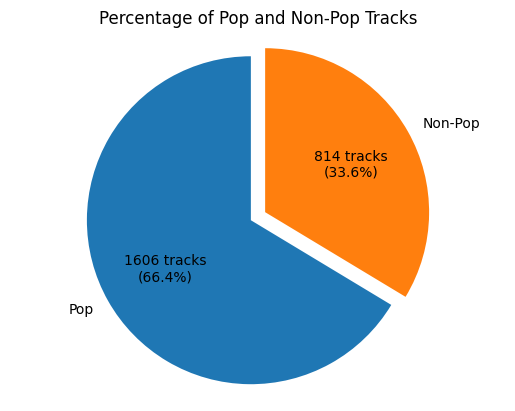

In [ ]:
# Pie chart of pop and non-pop tracks
num_pop_tracks = len(df[df['genre'] == 'pop'])
num_nonpop_tracks = len(df[df['genre'] == 'non-pop'])
total_tracks = len(df)

sizes = [num_pop_tracks, num_nonpop_tracks]
labels = ['Pop', 'Non-Pop']
explode = (0.1, 0)

patches, texts, autotexts = plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', startangle=90)

plt.title('Percentage of Pop and Non-Pop Tracks')
plt.axis('equal')
for i, text in enumerate(autotexts):
    text.set_text(f"{sizes[i]} tracks\n({sizes[i] / total_tracks * 100:.1f}%)")

plt.show()

In [ ]:
df.describe()

acousticness  danceability     duration       energy  instrumentalness  \
count   2420.000000   2420.000000  2420.000000  2420.000000       2420.000000   
mean       0.248388      0.646168     3.458161     0.658153          0.017882   
std        0.257595      0.135462     0.770673     0.199301          0.105646   
min        0.000025      0.144000     0.682833     0.019300          0.000000   
25%        0.041675      0.564000     3.098446     0.513000          0.000000   
50%        0.147500      0.663000     3.415617     0.679000          0.000000   
75%        0.386250      0.742000     3.780000     0.828000          0.000014   
max        0.992000      0.971000     9.666450     0.994000          0.983000   

               key     liveness     loudness         mode  speechiness  \
count  2420.000000  2420.000000  2420.000000  2420.000000   2420.00000   
mean      5.434298     0.184324    -6.171033     0.595868      0.11422   
std       3.565982     0.137168     3.063607     0.490825      0.11437   
min       0.000000     0.019800   -31.473000     0.000000      0.02270   
25%       2.000000     0.097400    -7.736250     0.000000      0.04030   
50%       6.000000     0.129000    -5.717500     1.000000      0.06330   
75%       8.000000     0.239000    -4.019000     1.000000      0.13700   
max      11.000000     0.963000     0.394000     1.000000      0.92300   

             tempo      valence  
count  2420.000000  2420.000000  
mean    120.260465     0.487615  
std      27.399252     0.227750  
min      46.923000     0.027700  
25%      99.949750     0.310000  
50%     120.008500     0.486000  
75%     137.728250     0.670000  
max     218.365000     0.973000

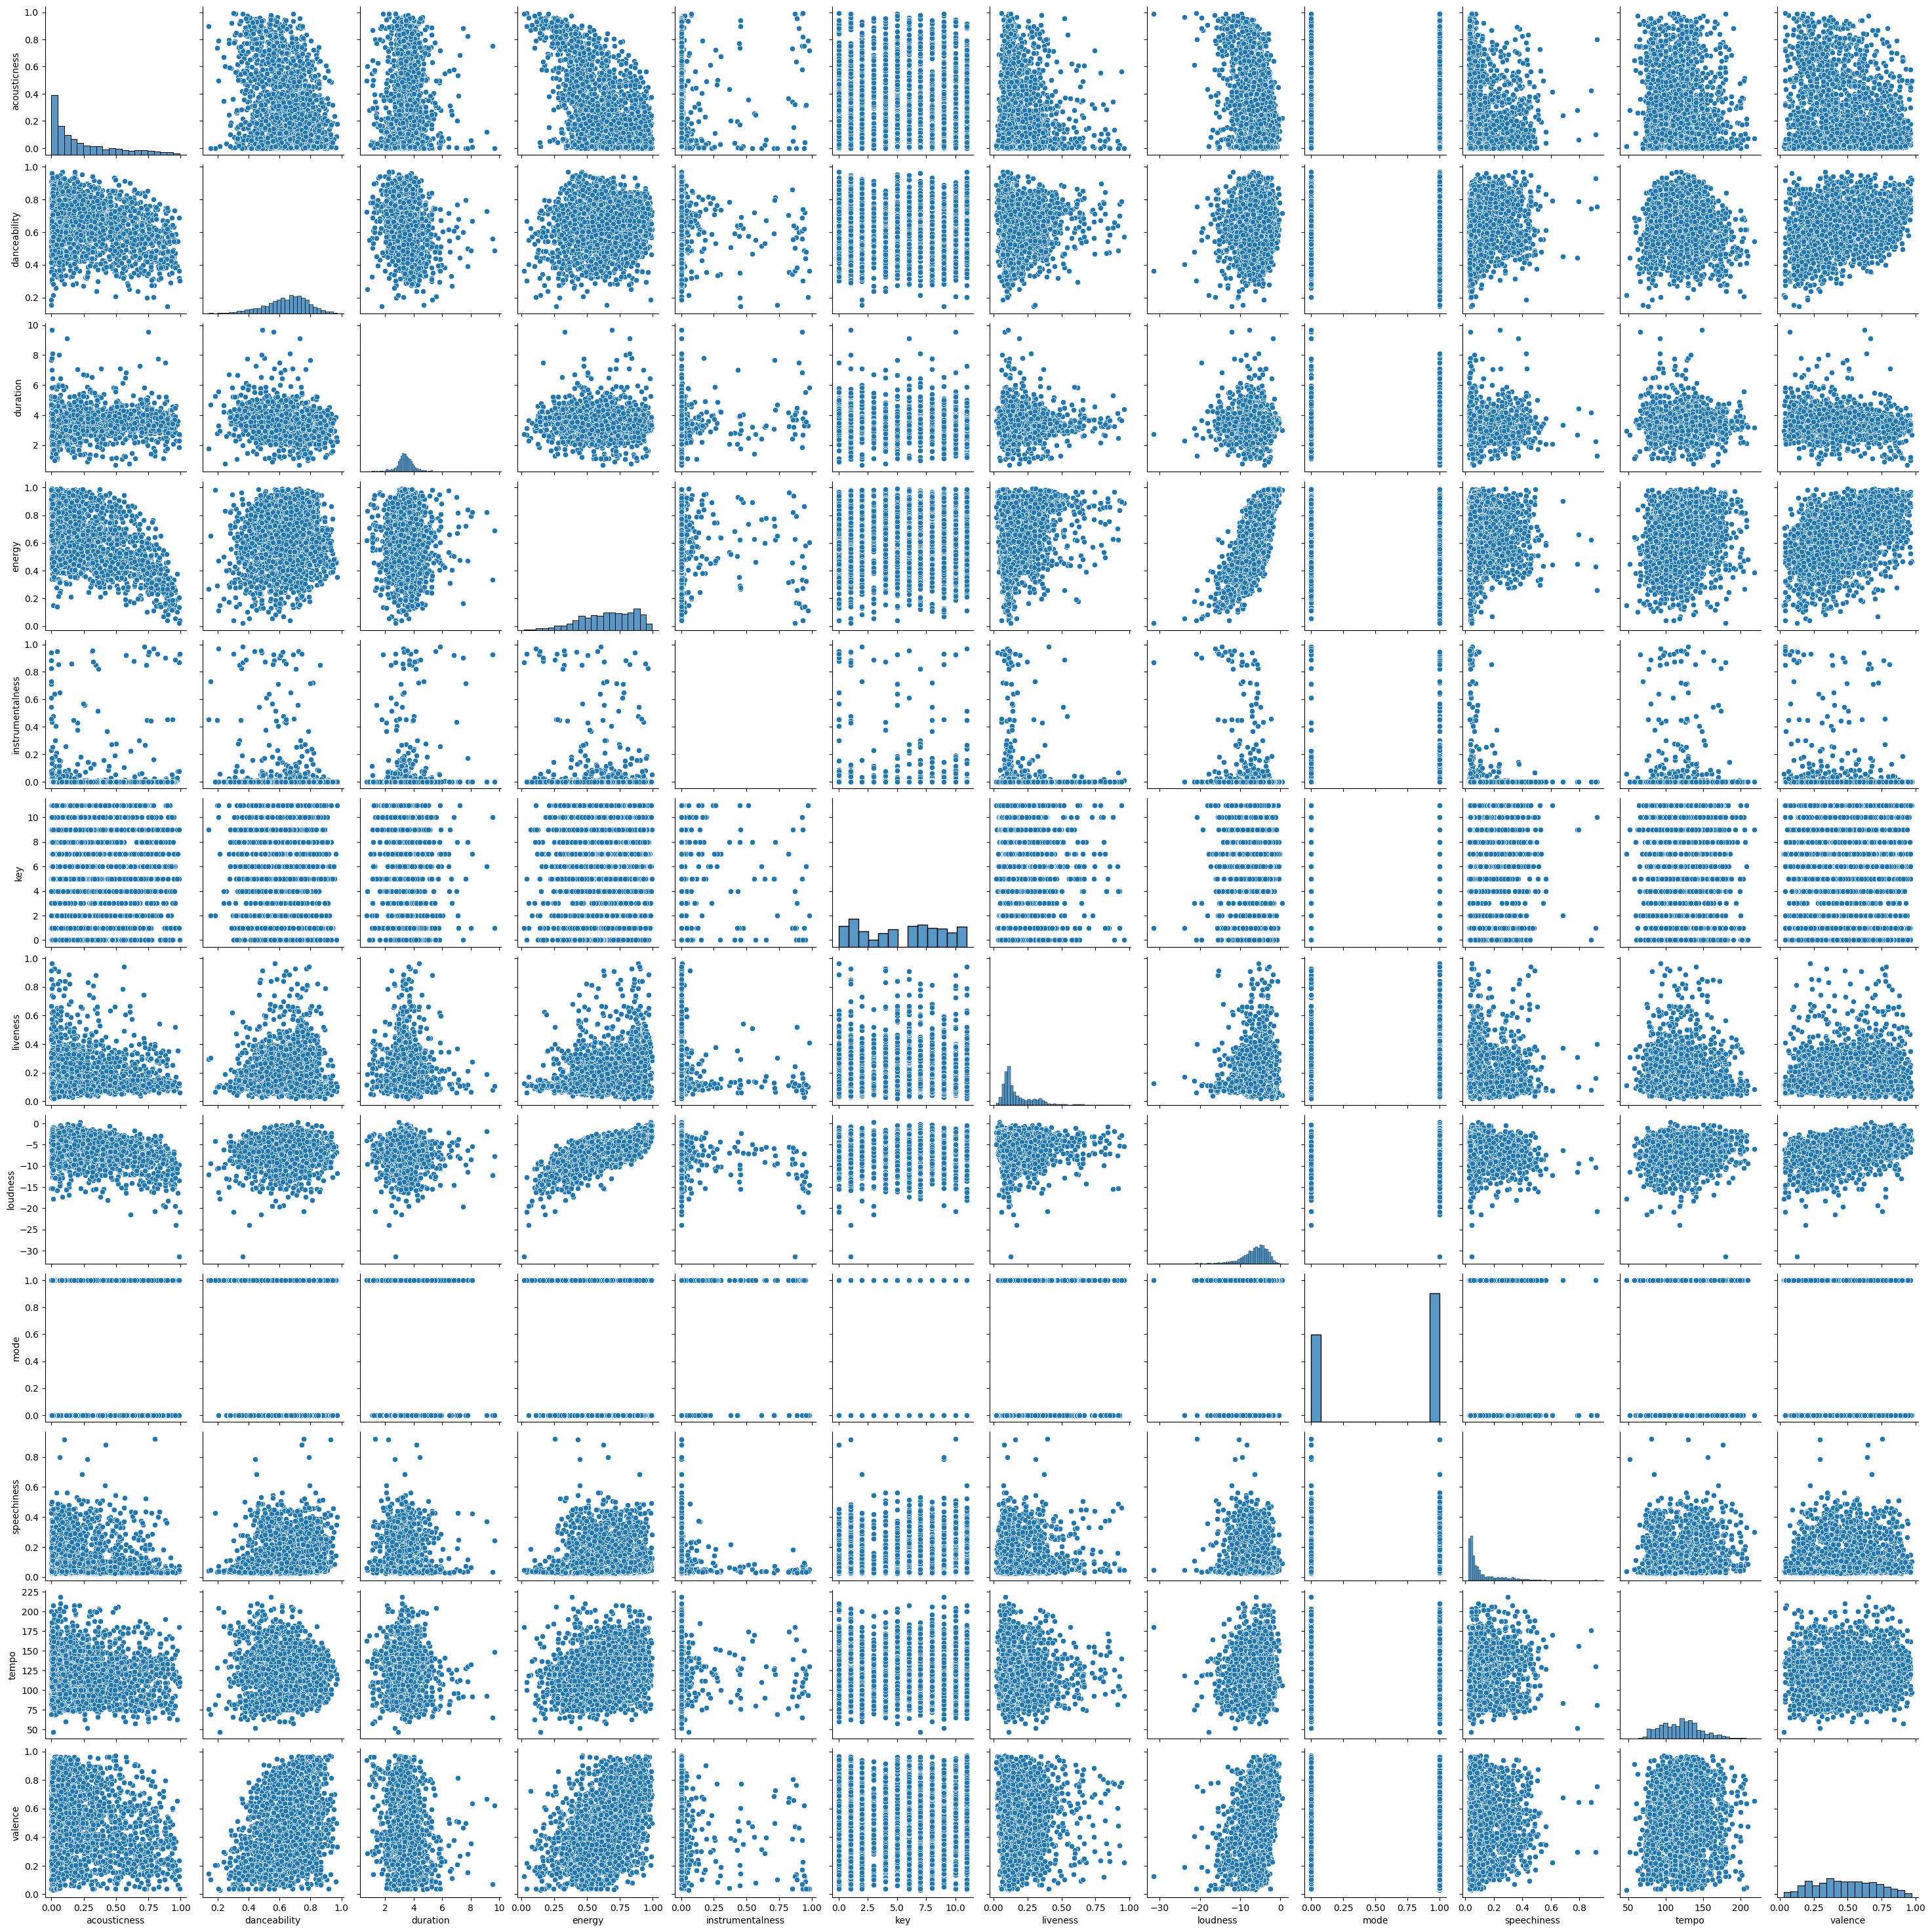

In [ ]:
sns.pairplot(df)

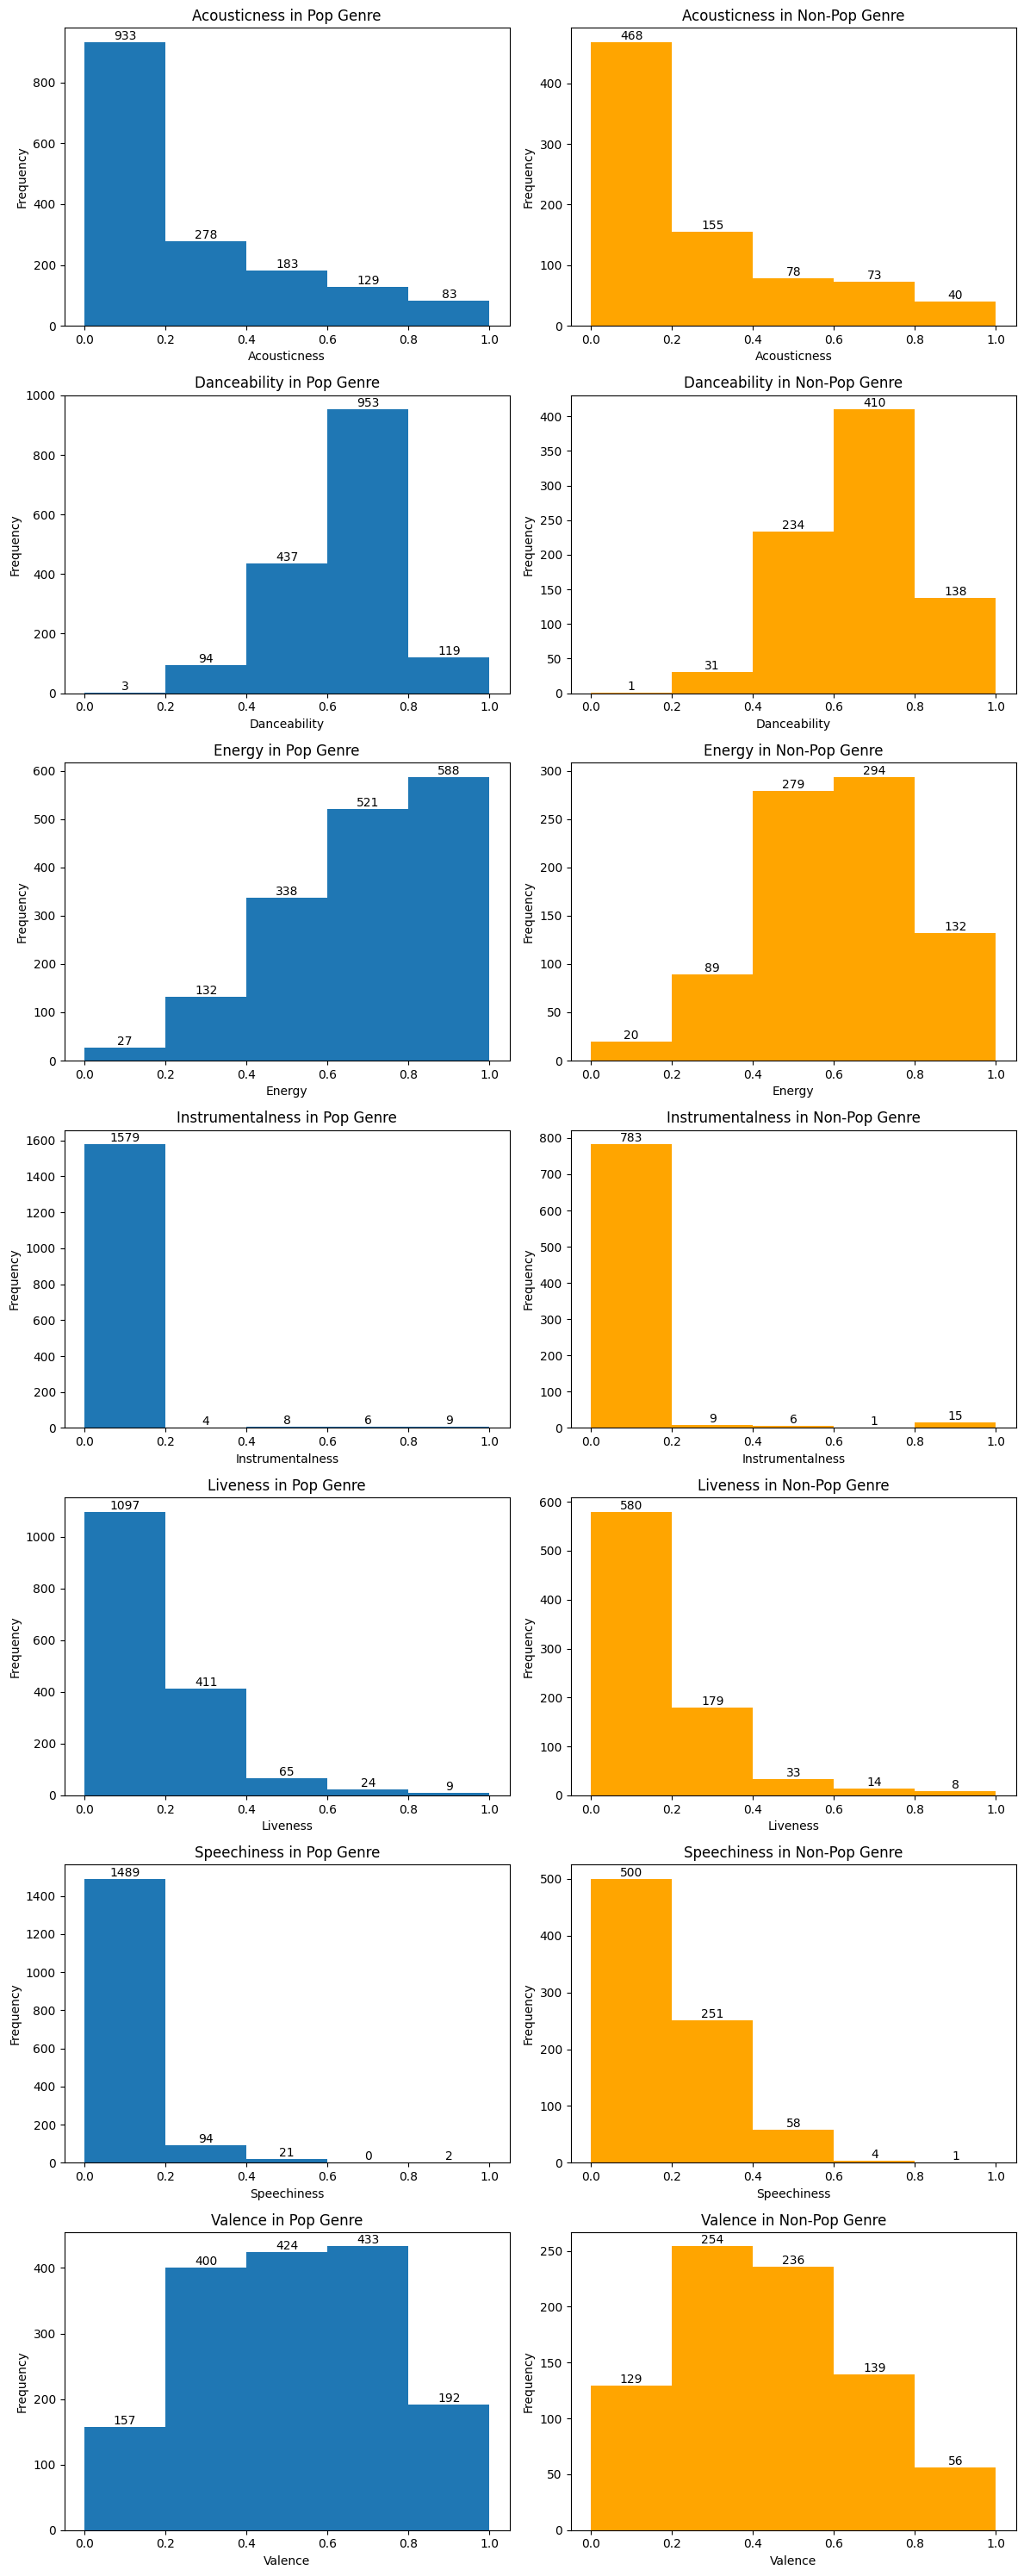

In [ ]:
# Ratio variables with scales 0.0 to 1.0
genres = ['pop', 'non-pop']
genre_names = ['Pop','Non-Pop']
variables = ['acousticness','danceability','energy','instrumentalness','liveness','speechiness','valence']
bins = [x/5 for x in range(6)]

fig, axes = plt.subplots(len(variables), len(genres), figsize=(12, 30), tight_layout=True)

for i, variable in enumerate(variables):
    for j, genre in enumerate(genres):
        data = df[df['genre'] == genre][variable]
        color = 'orange' if genre == 'non-pop' else None
        axes[i, j].hist(data, bins=bins, color=color)
        axes[i, j].set_xlabel(variable.capitalize())
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_title(f'{variable.capitalize()} in {genre_names[j]} Genre')

        for rect in axes[i, j].patches:
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_height()
            axes[i, j].text(x, y, int(y), ha='center', va='bottom')

plt.show()

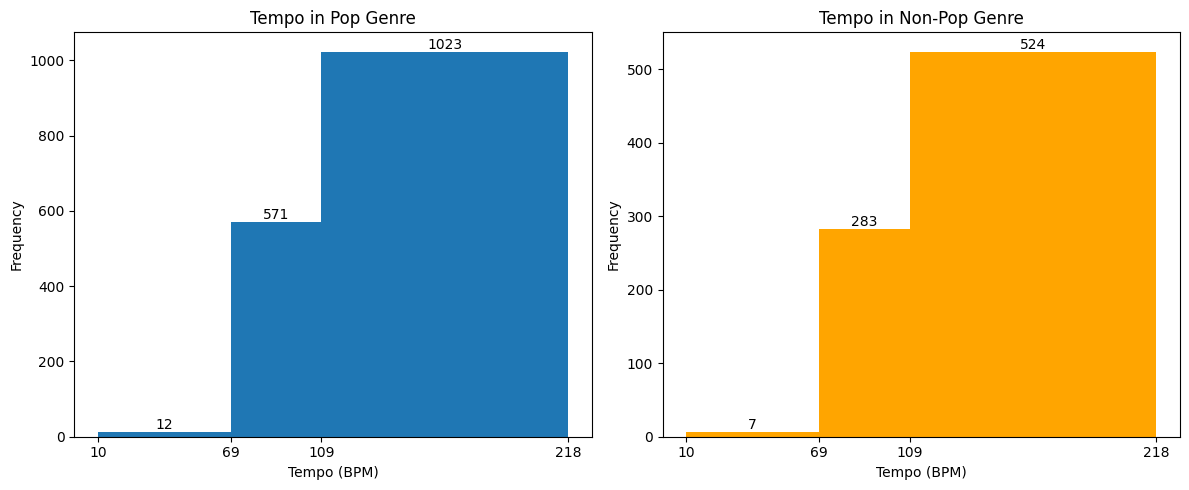

In [ ]:
# Ratio variables with custom scale
genres = ['pop', 'non-pop']
genre_names = ['Pop', 'Non-Pop']
variables = ['tempo']
bins = [10, 69, 109, df['tempo'].max()]

fig, axes = plt.subplots(len(variables), len(genres), figsize=(12, 5), tight_layout=True)

for i, variable in enumerate(variables):
    for j, genre in enumerate(genres):
        data = df[df['genre'] == genre][variable]
        color = 'orange' if genre == 'non-pop' else None
        n, bins, patches = axes[j].hist(data, bins=bins, color=color)
        axes[j].set_xlabel(f'{variable.capitalize()} (BPM)')
        axes[j].set_ylabel('Frequency')
        axes[j].set_title(f'{variable.capitalize()} in {genre_names[j]} Genre')

        for rect in patches:
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_height()
            axes[j].text(x, y, int(y), ha='center', va='bottom')

        axes[j].set_xticks(bins)
        axes[j].set_xticklabels([int(x) for x in bins])

plt.show()

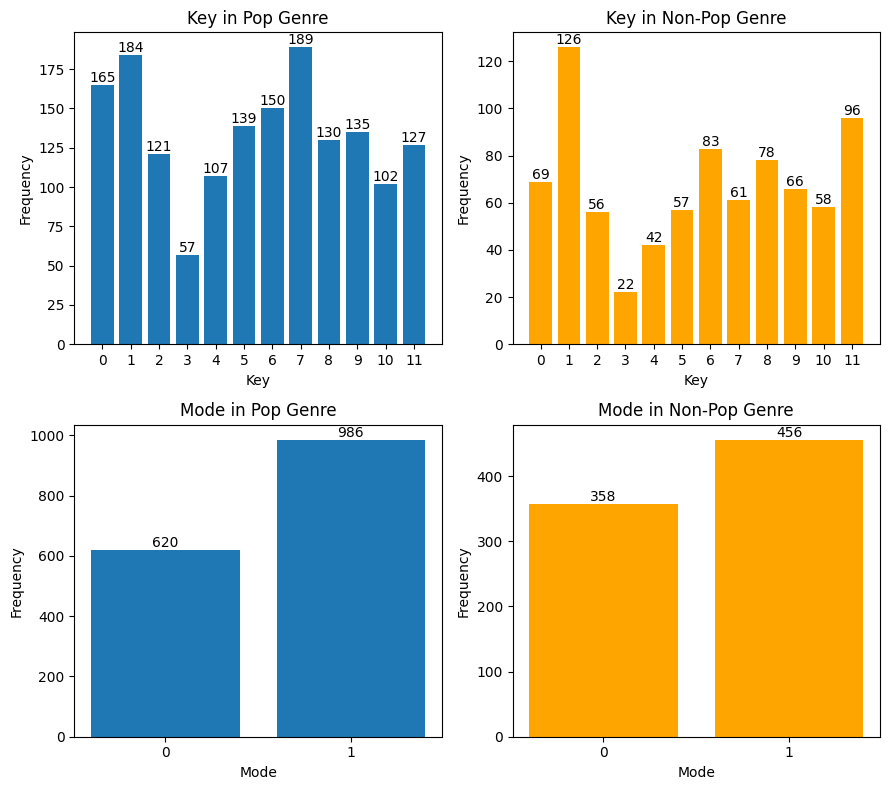

In [ ]:
# Interval variables - not continuous
genres = ['pop', 'non-pop']
genre_names = ['Pop', 'Non-Pop']
variables = ['key', 'mode']

fig, axes = plt.subplots(len(variables), len(genres), figsize=(9, 8), tight_layout=True)

for i, variable in enumerate(variables):
    for j, genre in enumerate(genres):
        data = df[df['genre'] == genre][variable]
        color = 'orange' if genre == 'non-pop' else None
        counts = data.value_counts().sort_index()
        axes[i, j].bar(counts.index, counts.values, color=color)
        axes[i, j].set_xlabel(variable.capitalize())
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_title(f'{variable.capitalize()} in {genre_names[j]} Genre')
        axes[i, j].set_xticks(counts.index)
        axes[i, j].set_xticklabels(counts.index.astype(int))

        for rect in axes[i, j].patches:
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_height()
            axes[i, j].text(x, y, int(y), ha='center', va='bottom')

plt.show()

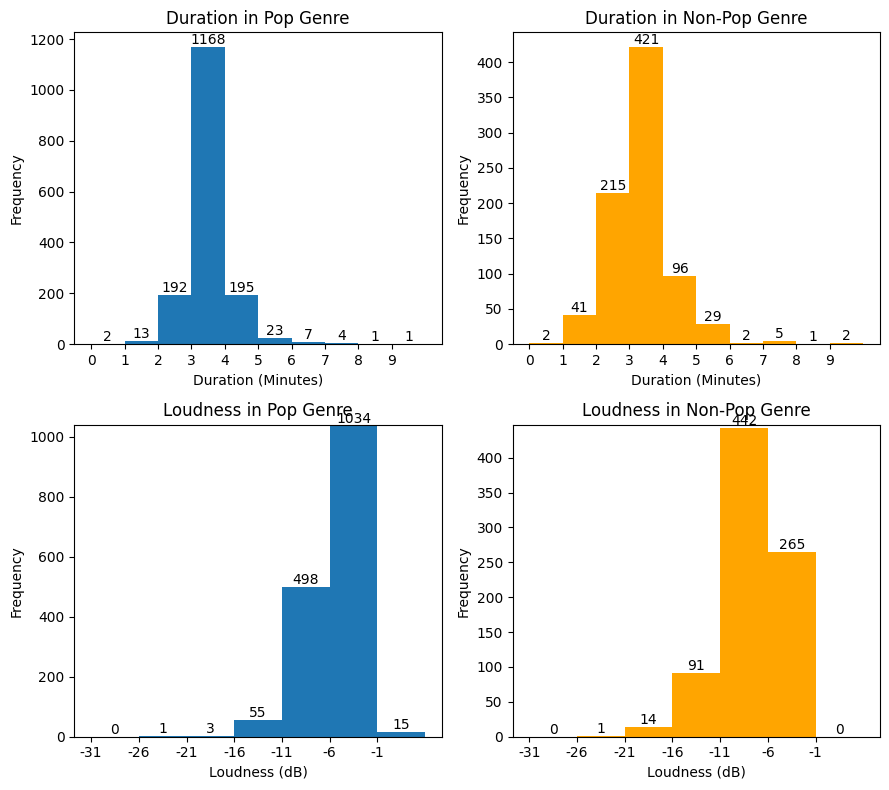

In [ ]:
# Interval variables - continuous
genres = ['pop', 'non-pop']
genre_names = ['Pop', 'Non-Pop']
variables = ['duration', 'loudness']

duration_min = min(df[df['genre'] == 'pop']['duration'].min(), df[df['genre'] == 'non-pop']['duration'].min())
duration_max = max(df[df['genre'] == 'pop']['duration'].max(), df[df['genre'] == 'non-pop']['duration'].max())
loudness_min = min(df[df['genre'] == 'pop']['loudness'].min(), df[df['genre'] == 'non-pop']['loudness'].min())
loudness_max = max(df[df['genre'] == 'pop']['loudness'].max(), df[df['genre'] == 'non-pop']['loudness'].max())

fig, axes = plt.subplots(len(variables), len(genres), figsize=(9, 8), tight_layout=True)

for i, variable in enumerate(variables):
    for j, genre in enumerate(genres):
        data = df[df['genre'] == genre][variable]
        color = 'orange' if genre == 'non-pop' else None
        if variable == 'duration':
            counts, bins, _ = axes[i, j].hist(data, bins=range(int(duration_min), int(duration_max) + 2), color=color)
            axes[i, j].set_xticks(range(int(duration_min), int(duration_max) + 1, 1))
            axes[i, j].set_xticklabels(range(int(duration_min), int(duration_max) + 1, 1))
            axes[i, j].set_xlabel(f'{variable.capitalize()} (Minutes)')  # Modify the x-axis label
        elif variable == 'loudness':
            counts, bins, _ = axes[i, j].hist(data, bins=range(int(loudness_min), int(loudness_max) + 6, 5), color=color)
            axes[i, j].set_xticks(range(int(loudness_min), int(loudness_max) + 1, 5))
            axes[i, j].set_xticklabels(range(int(loudness_min), int(loudness_max) + 1, 5))
            axes[i, j].set_ylim(0, max(counts) + 5)  # Set y-axis limits based on maximum count
            axes[i, j].set_xlabel(f'{variable.capitalize()} (dB)')  # Modify the x-axis label

        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_title(f'{variable.capitalize()} in {genre_names[j]} Genre')

        for count, bin_value in zip(counts, bins[:-1]):
            axes[i, j].annotate(str(int(count)), xy=(bin_value + (bins[1] - bins[0]) / 2, count), ha='center', va='bottom')

plt.show()

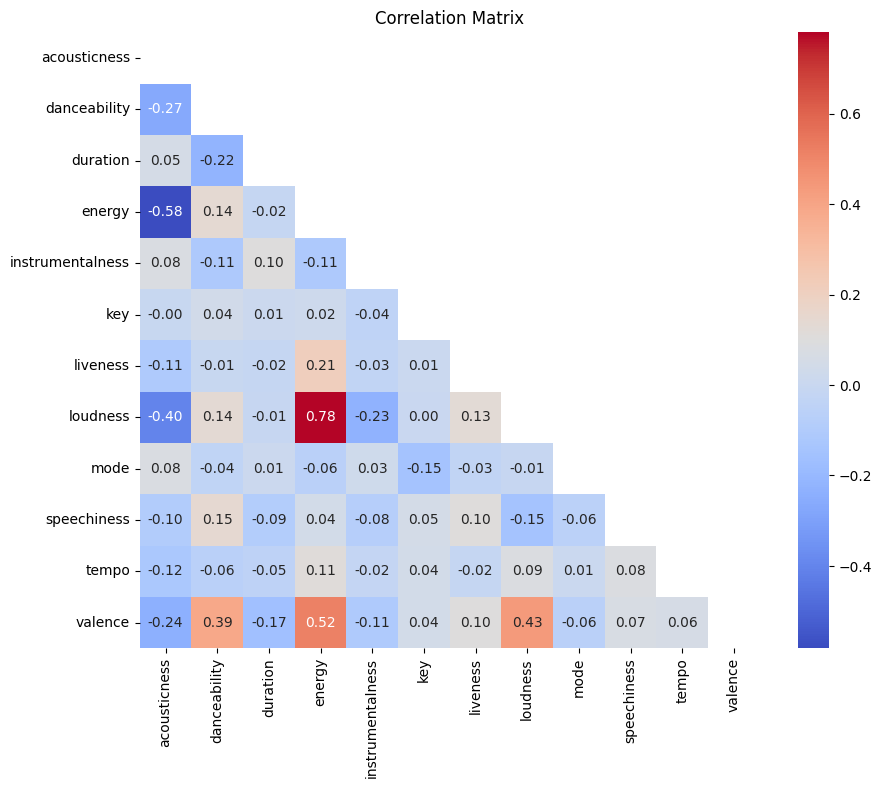

In [ ]:
# Correlation matrix
variables = ['acousticness','danceability','duration','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','valence']
df_selected = df[variables]
correlation_matrix = df_selected.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask = mask, annot = True, fmt = ".2f", cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

# **Step 3: Data Transformation**

# Data Encoding

In [ ]:
# Perform encoding on genre
df['genre'] = df['genre'].replace({'pop': 1, 'non-pop': 0})

# Data Normalisation

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Data normalisation on duration, loudness, and tempo
duration_values = df['duration'].values.reshape(-1, 1)
key_values = df['key'].values.reshape(-1, 1)
loudness_values = df['loudness'].values.reshape(-1, 1)
tempo_values = df['tempo'].values.reshape(-1, 1)

scaler = MinMaxScaler()

scaled_duration = scaler.fit_transform(duration_values)
scaled_key = scaler.fit_transform(key_values)
scaled_loudness = scaler.fit_transform(loudness_values)
scaled_tempo = scaler.fit_transform(tempo_values)

df['duration'] = scaled_duration
df['key'] = scaled_key
df['loudness'] = scaled_loudness
df['tempo'] = scaled_tempo

In [ ]:
df.head(5)

artist                      track_title  \
1  Girls' Generation-Oh!GG                       Lil’ Touch   
2        Cheat Codes, CADE                    Stay With You   
3                     Lauv                        Never Not   
7                    Lorde                         Supercut   
8      TOMORROW X TOGETHER  9 and Three Quarters (Run Away)   

                 track_id release_date  genre  acousticness  danceability  \
1  4D5Ode2OfZMxIwQyvmhUe8   2018-09-05      1       0.01140         0.791   
2  7q8jJ1XZEliBakZSUMFde5   2017-05-26      1       0.10200         0.744   
3  3ZPBZH2k9p306C1bu7bkhC   2018-05-31      1       0.69100         0.471   
7  6K8VQ84MqhsoakN5MjrnVR   2017-06-16      1       0.21900         0.562   
8  3psGiE7CXKwFpCH06Gk8tm   2019-10-21      1       0.00428         0.629   

   duration  energy  instrumentalness       key  liveness  loudness  mode  \
1  0.276199   0.789          0.000000  1.000000    0.3010  0.840336     0   
2  0.316689   0.513          0.000002  0.181818    0.0894  0.689773     0   
3  0.309879   0.220          0.000000  0.454545    0.1040  0.697587     1   
7  0.438828   0.437          0.000022  0.000000    0.0806  0.666646     1   
8  0.316979   0.763          0.000000  0.090909    0.1150  0.849248     1   

   speechiness     tempo  valence  
1       0.1040  0.380228    0.669  
2       0.0411  0.542784    0.353  
3       0.0370  0.506241    0.260  
7       0.0520  0.454550    0.150  
8       0.0628  0.478570    0.521

# **Step 4: Train Test Split**

In [ ]:
x = df[['acousticness','danceability','duration','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','valence']]
y = df['genre']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print("Number of training samples:", len(x_train))
print("Number of test samples:", len(x_test))

Number of training samples: 1936
Number of test samples: 484


# **Step 5: Data Balancing on Training Data**

In [ ]:
# Check genre percentages on training data
counts = y_train.value_counts()
percentages = (counts / len(y_train)) * 100

for category in counts.index:
    count = counts[category]
    percentage = percentages[category]
    print(f"{category}: Count={count}, Percentage={percentage:.2f}%")

majority_count = counts.max()
minority_count = counts.min()
imbalanced_ratio = majority_count / minority_count
print(f"Imbalanced Ratio: {imbalanced_ratio:.2f}")

1: Count=1289, Percentage=66.58%
0: Count=647, Percentage=33.42%
Imbalanced Ratio: 1.99


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

# Check genre count after applying SMOTE
print("Class distribution after SMOTE:")
print(y_train.value_counts())

Class distribution after SMOTE:
1    1289
0    1289
Name: genre, dtype: int64


# **Step 6: Modelling**

# **Step 6a: Modelling with All Variables**

# Logistic Regression

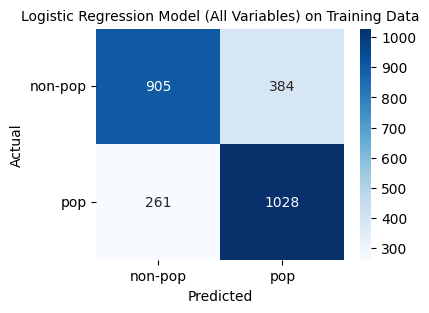

Logistic Regression Precision: 0.7280453257790368
Logistic Regression Recall: 0.7975174553917765
Logistic Regression F1-score: 0.7611995557201037


In [ ]:
logreg = LogisticRegression()
y_pred = cross_val_predict(logreg, x_train, y_train, cv=5)
cm_logreg = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues")
tick_labels = ['non-pop', 'pop']
plt.gca().set_xticklabels(tick_labels, rotation=0)
plt.gca().set_yticklabels(tick_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Model (All Variables) on Training Data', fontsize=10)
plt.show()

logreg1_precision_train = precision_score(y_train, y_pred)
print("Logistic Regression Precision:", logreg1_precision_train)
logreg1_recall_train = recall_score(y_train, y_pred)
print("Logistic Regression Recall:", logreg1_recall_train)
logreg1_f1_train = f1_score(y_train, y_pred)
print("Logistic Regression F1-score:", logreg1_f1_train)

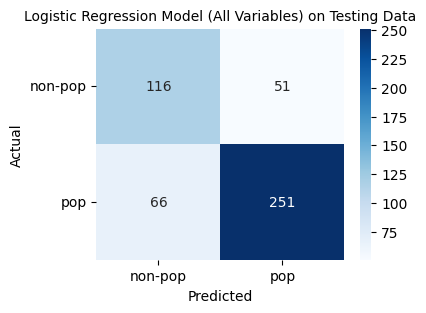

Logistic Regression Precision: 0.8311258278145696
Logistic Regression Recall: 0.7917981072555205
Logistic Regression F1-score: 0.8109854604200324


In [ ]:
logreg = logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
cm_logreg = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues")
tick_labels = ['non-pop', 'pop']
plt.gca().set_xticklabels(tick_labels, rotation=0)
plt.gca().set_yticklabels(tick_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Model (All Variables) on Testing Data', fontsize=10)
plt.show()

logreg1_precision_test = precision_score(y_test, y_pred)
print("Logistic Regression Precision:", logreg1_precision_test)
logreg1_recall_test = recall_score(y_test, y_pred)
print("Logistic Regression Recall:", logreg1_recall_test)
logreg1_f1_test = f1_score(y_test, y_pred)
print("Logistic Regression F1-score:", logreg1_f1_test)

In [ ]:
x_train2 = sm.add_constant(x_train)
logit_model = sm.Logit(y_train, x_train2)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.514705
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  genre   No. Observations:                 2578
Model:                          Logit   Df Residuals:                     2565
Method:                           MLE   Df Model:                           12
Date:                Thu, 20 Jul 2023   Pseudo R-squ.:                  0.2574
Time:                        05:27:19   Log-Likelihood:                -1326.9
converged:                       True   LL-Null:                       -1786.9
Covariance Type:            nonrobust   LLR p-value:                2.841e-189
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.2720      0.727    -10.005      0.000      -8.697      -5.847
acousticnes

# KNN

In [ ]:
# Determining best k and distance metric to use
param_grid = {
    'n_neighbors': list(range(3, round(math.sqrt(len(y_train))), 2)),
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
scoring = make_scorer(f1_score)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=scoring)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3}


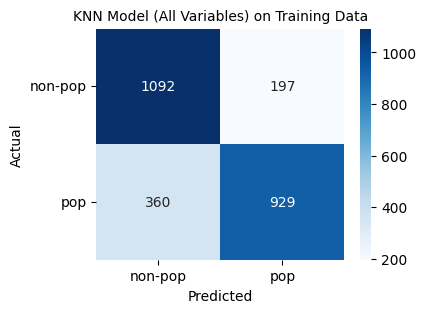

KNN Precision: 0.8250444049733571
KNN Recall: 0.7207137315748642
KNN F1-score: 0.7693581780538301


In [ ]:
knn = KNeighborsClassifier(**best_params)
y_pred = cross_val_predict(knn, x_train, y_train, cv=5)
cm_knn = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
tick_labels = ['non-pop', 'pop']
plt.gca().set_xticklabels(tick_labels, rotation=0)
plt.gca().set_yticklabels(tick_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Model (All Variables) on Training Data', fontsize=10)
plt.show()

knn1_precision_train = precision_score(y_train, y_pred)
print("KNN Precision:", knn1_precision_train)
knn1_recall_train = recall_score(y_train, y_pred)
print("KNN Recall:", knn1_recall_train)
knn1_f1_train = f1_score(y_train, y_pred)
print("KNN F1-score:", knn1_f1_train)

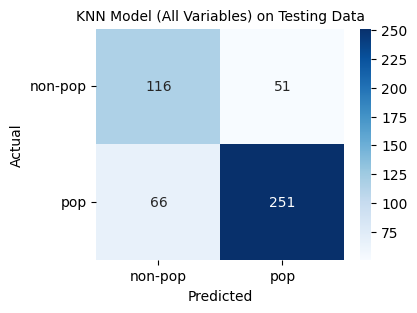

KNN Precision: 0.7871621621621622
KNN Recall: 0.7350157728706624
KNN F1-score: 0.7601957585644372


In [ ]:
knn = knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
cm_knn = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues")
tick_labels = ['non-pop', 'pop']
plt.gca().set_xticklabels(tick_labels, rotation=0)
plt.gca().set_yticklabels(tick_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Model (All Variables) on Testing Data', fontsize=10)
plt.show()

knn1_precision_test = precision_score(y_test, y_pred)
print("KNN Precision:", knn1_precision_test)
knn1_recall_test = recall_score(y_test, y_pred)
print("KNN Recall:", knn1_recall_test)
knn1_f1_test = f1_score(y_test, y_pred)
print("KNN F1-score:", knn1_f1_test)

# **Step 6b: Modelling with Multicollinearity Removed**

# Multicollinearity Test

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculating VIF
def calc_vif(X):
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
  return(vif)

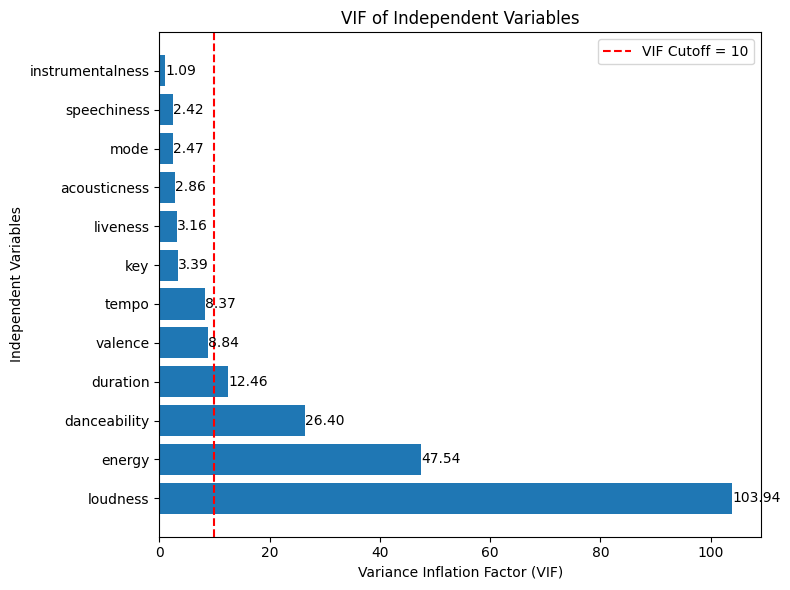

In [ ]:
# Viewing VIF of independent variables
vif_x = calc_vif(x_train)
vif_x_sorted = vif_x.sort_values(by='VIF', ascending=False)
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(vif_x_sorted['variables'], vif_x_sorted['VIF'])
ax.set_xlabel('Variance Inflation Factor (VIF)')
ax.set_ylabel('Independent Variables')
ax.set_title('VIF of Independent Variables')
for i, vif in enumerate(vif_x_sorted['VIF']):
    ax.text(vif, i, f'{vif:.2f}', va = 'center')
ax.axvline(x=10, color='red', linestyle='--', linewidth=1.5, label='VIF Cutoff = 10')
ax.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

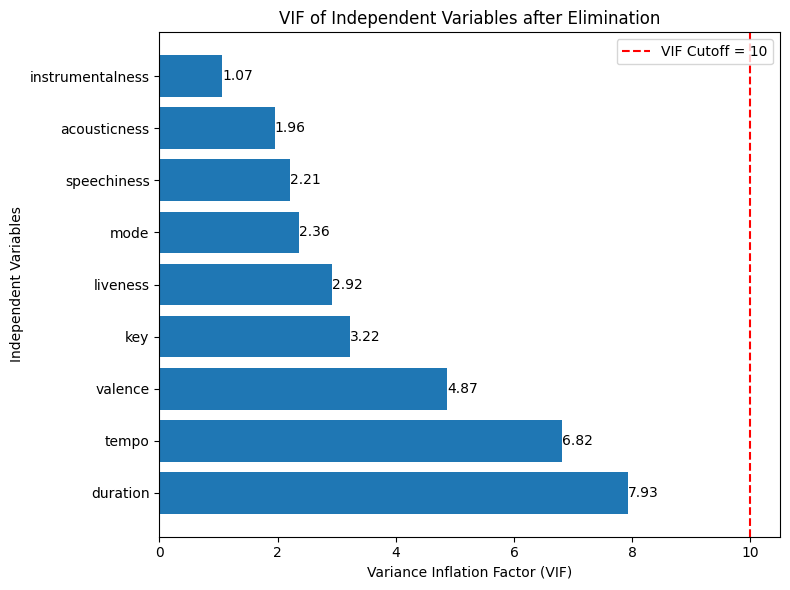

In [ ]:
# Removing variables with VIF > 10 one-by-one
x_vif = x_train.drop(columns = ['danceability','energy','loudness'])

# Viewing VIF of independent variables
vif_x = calc_vif(x_vif)
vif_x_sorted = vif_x.sort_values(by = 'VIF', ascending=False)
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(vif_x_sorted['variables'], vif_x_sorted['VIF'])
ax.set_xlabel('Variance Inflation Factor (VIF)')
ax.set_ylabel('Independent Variables')
ax.set_title('VIF of Independent Variables after Elimination')
for i, vif in enumerate(vif_x_sorted['VIF']):
    ax.text(vif, i, f'{vif:.2f}', va = 'center')
ax.axvline(x = 10, color = 'red', linestyle = '--', linewidth = 1.5, label = 'VIF Cutoff = 10')
ax.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

In [ ]:
# Print final list of independent variables to be used
print(x_vif.columns)

Index(['acousticness', 'duration', 'instrumentalness', 'key', 'liveness',
       'mode', 'speechiness', 'tempo', 'valence'],
      dtype='object')


In [ ]:
x_train2 = x_train[x_vif.columns]
x_test2 = x_test[x_vif.columns]

# Logistic Regression

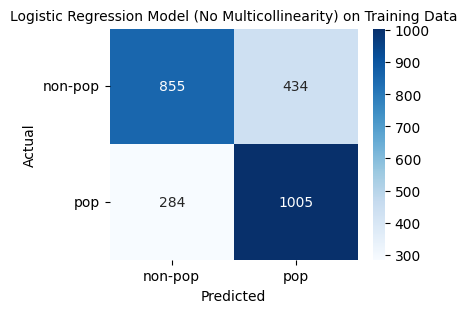

Logistic Regression Precision: 0.6984016678248783
Logistic Regression Recall: 0.7796741660201707
Logistic Regression F1-score: 0.7368035190615835


In [ ]:
logreg2 = LogisticRegression()
y_pred = cross_val_predict(logreg2, x_train2, y_train, cv=5)
cm_logreg = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues")
tick_labels = ['non-pop', 'pop']
plt.gca().set_xticklabels(tick_labels, rotation=0)
plt.gca().set_yticklabels(tick_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Model (No Multicollinearity) on Training Data', fontsize=10)
plt.show()

logreg2_precision_train = precision_score(y_train, y_pred)
print("Logistic Regression Precision:", logreg2_precision_train)
logreg2_recall_train = recall_score(y_train, y_pred)
print("Logistic Regression Recall:", logreg2_recall_train)
logreg2_f1_train = f1_score(y_train, y_pred)
print("Logistic Regression F1-score:", logreg2_f1_train)

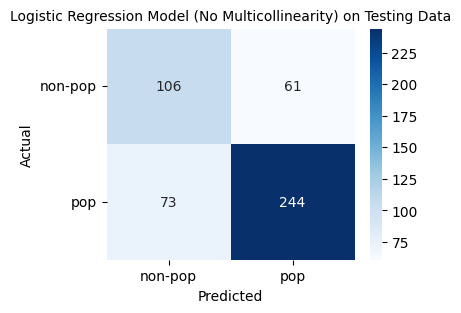

Logistic Regression Precision: 0.8
Logistic Regression Recall: 0.7697160883280757
Logistic Regression F1-score: 0.7845659163987139


In [ ]:
logreg2 = logreg2.fit(x_train2, y_train)
y_pred = logreg2.predict(x_test2)
cm_logreg = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues")
tick_labels = ['non-pop', 'pop']
plt.gca().set_xticklabels(tick_labels, rotation=0)
plt.gca().set_yticklabels(tick_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Model (No Multicollinearity) on Testing Data', fontsize=10)
plt.show()

logreg2_precision_test = precision_score(y_test, y_pred)
print("Logistic Regression Precision:", logreg2_precision_test)
logreg2_recall_test = recall_score(y_test, y_pred)
print("Logistic Regression Recall:", logreg2_recall_test)
logreg2_f1_test = f1_score(y_test, y_pred)
print("Logistic Regression F1-score:", logreg2_f1_test)

In [ ]:
x_train3 = sm.add_constant(x_train2)
logit_model = sm.Logit(y_train, x_train3)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.568446
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  genre   No. Observations:                 2578
Model:                          Logit   Df Residuals:                     2568
Method:                           MLE   Df Model:                            9
Date:                Thu, 20 Jul 2023   Pseudo R-squ.:                  0.1799
Time:                        05:27:40   Log-Likelihood:                -1465.5
converged:                       True   LL-Null:                       -1786.9
Covariance Type:            nonrobust   LLR p-value:                1.252e-132
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.4665      0.272     -5.389      0.000      -2.000      -0.933
acousticnes

# KNN

In [ ]:
# Determining best k and distance metric to use
param_grid = {
    'n_neighbors': list(range(3, round(math.sqrt(len(y_train))), 2)),
    'metric': ['euclidean', 'manhattan']
}

knn2 = KNeighborsClassifier()
scoring = make_scorer(f1_score)
grid_search = GridSearchCV(knn2, param_grid, cv=5, scoring=scoring)
grid_search.fit(x_train2, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3}


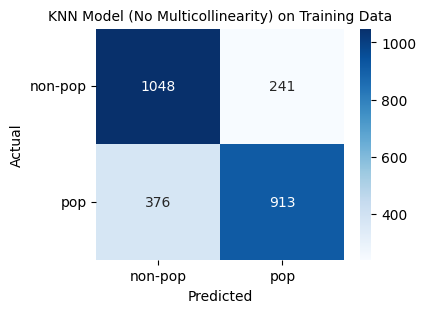

KNN Precision: 0.791161178509532
KNN Recall: 0.7083010085337471
KNN F1-score: 0.7474416700777733


In [ ]:
knn2 = KNeighborsClassifier(**best_params)
y_pred = cross_val_predict(knn2, x_train2, y_train, cv=5)
cm_knn = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
tick_labels = ['non-pop', 'pop']
plt.gca().set_xticklabels(tick_labels, rotation=0)
plt.gca().set_yticklabels(tick_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Model (No Multicollinearity) on Training Data', fontsize=10)
plt.show()

knn2_precision_train = precision_score(y_train, y_pred)
print("KNN Precision:", knn2_precision_train)
knn2_recall_train = recall_score(y_train, y_pred)
print("KNN Recall:", knn2_recall_train)
knn2_f1_train = f1_score(y_train, y_pred)
print("KNN F1-score:", knn2_f1_train)

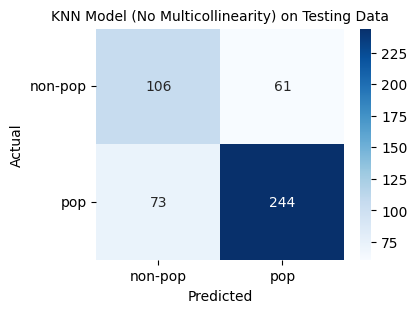

KNN Precision: 0.7833333333333333
KNN Recall: 0.7413249211356467
KNN F1-score: 0.7617504051863857


In [ ]:
knn2 = knn2.fit(x_train2, y_train)
y_pred = knn2.predict(x_test2)
cm_knn = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues")
tick_labels = ['non-pop', 'pop']
plt.gca().set_xticklabels(tick_labels, rotation=0)
plt.gca().set_yticklabels(tick_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Model (No Multicollinearity) on Testing Data', fontsize=10)
plt.show()

knn2_precision_test = precision_score(y_test, y_pred)
print("KNN Precision:", knn2_precision_test)
knn2_recall_test = recall_score(y_test, y_pred)
print("KNN Recall:", knn2_recall_test)
knn2_f1_test = f1_score(y_test, y_pred)
print("KNN F1-score:", knn2_f1_test)

# **Step 7. Final Comparison**

In [ ]:
from tabulate import tabulate

models = ['Logistic Regression', 'KNN']
param_types = ['All Variables', 'No Multicollinearity']

metrics = ['Precision', 'Recall', 'F1-Score']

values = [
    [[round(logreg1_precision_train, 3), round(logreg1_precision_test, 3),
      round(logreg1_recall_train, 3), round(logreg1_recall_test, 3),
      round(logreg1_f1_train, 3), round(logreg1_f1_test, 3)],
     [round(logreg2_precision_train, 3), round(logreg2_precision_test, 3),
      round(logreg2_recall_train, 3), round(logreg2_recall_test, 3),
      round(logreg2_f1_train, 3), round(logreg2_f1_test, 3)]],
    [[round(knn1_precision_train, 3), round(knn1_precision_test, 3),
      round(knn1_recall_train, 3), round(knn1_recall_test, 3),
      round(knn1_f1_train, 3), round(knn1_f1_test, 3)],
     [round(knn2_precision_train, 3), round(knn2_precision_test, 3),
      round(knn2_recall_train, 3), round(knn2_recall_test, 3),
      round(knn2_f1_train, 3), round(knn2_f1_test, 3)]]
]

table_data = []
for model, vals in zip(models, values):
    for param_type, val in zip(param_types, vals):
        row = [f"{model} - {param_type}"]
        for i in range(0, len(val), 2):
            row.extend(val[i:i+2])
        table_data.append(row)

headers = ['Model/Parameter']
for metric in metrics:
    headers.append(f"{metric} Train")
    headers.append(f"{metric} Test")

table = tabulate(table_data, headers=headers, floatfmt=".3f", tablefmt="fancy_grid")
print(table)

╒════════════════════════════════════════════╤═══════════════════╤══════════════════╤════════════════╤═══════════════╤══════════════════╤═════════════════╕
│ Model/Parameter                            │   Precision Train │   Precision Test │   Recall Train │   Recall Test │   F1-Score Train │   F1-Score Test │
╞════════════════════════════════════════════╪═══════════════════╪══════════════════╪════════════════╪═══════════════╪══════════════════╪═════════════════╡
│ Logistic Regression - All Variables        │             0.728 │            0.831 │          0.798 │         0.792 │            0.761 │           0.811 │
├────────────────────────────────────────────┼───────────────────┼──────────────────┼────────────────┼───────────────┼──────────────────┼─────────────────┤
│ Logistic Regression - No Multicollinearity │             0.698 │            0.800 │          0.780 │         0.770 │            0.737 │           0.785 │
├────────────────────────────────────────────┼──────────────────

# **Step 8. Permutation Importance**

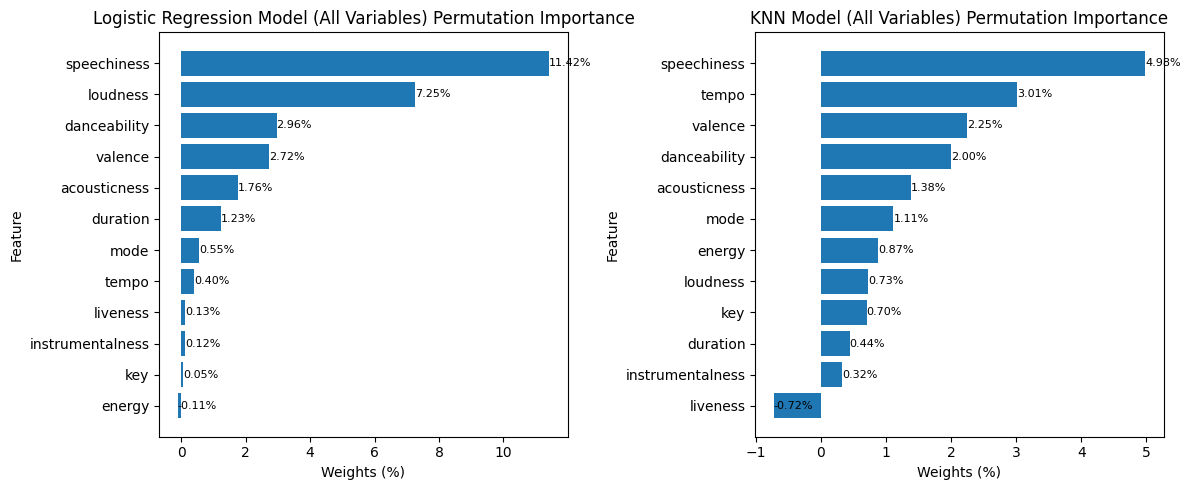

In [ ]:
feature_names = x_train.columns

# Logistic Regression Permutation Importance
result_logreg = permutation_importance(logreg, x_test, y_test, n_repeats=100, random_state=42)
average_weights_logreg = result_logreg.importances_mean
sorted_indices_logreg = np.argsort(average_weights_logreg)
sorted_weights_logreg = average_weights_logreg[sorted_indices_logreg]
sorted_features_logreg = [feature_names[i] for i in sorted_indices_logreg]
sorted_weights_percentage_logreg = sorted_weights_logreg * 100

# KNN Permutation Importance
result_knn = permutation_importance(knn, x_test, y_test, n_repeats=100, random_state=42)
average_weights_knn = result_knn.importances_mean
sorted_indices_knn = np.argsort(average_weights_knn)
sorted_weights_knn = average_weights_knn[sorted_indices_knn]
sorted_features_knn = [feature_names[i] for i in sorted_indices_knn]
sorted_weights_percentage_knn = sorted_weights_knn * 100

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bars_logreg = ax1.barh(range(len(sorted_features_logreg)), sorted_weights_percentage_logreg)
ax1.set_yticks(range(len(sorted_features_logreg)))
ax1.set_yticklabels(sorted_features_logreg)
ax1.set_xlabel('Weights (%)')
ax1.set_ylabel('Feature')
ax1.set_title('Logistic Regression Model (All Variables) Permutation Importance')
for i, weight in enumerate(sorted_weights_percentage_logreg):
    ax1.text(weight, i, f'{weight:.2f}%', va='center', fontsize=8)

bars_knn = ax2.barh(range(len(sorted_features_knn)), sorted_weights_percentage_knn)
ax2.set_yticks(range(len(sorted_features_knn)))
ax2.set_yticklabels(sorted_features_knn)
ax2.set_xlabel('Weights (%)')
ax2.set_ylabel('Feature')
ax2.set_title('KNN Model (All Variables) Permutation Importance')
for i, weight in enumerate(sorted_weights_percentage_knn):
    ax2.text(weight, i, f'{weight:.2f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()

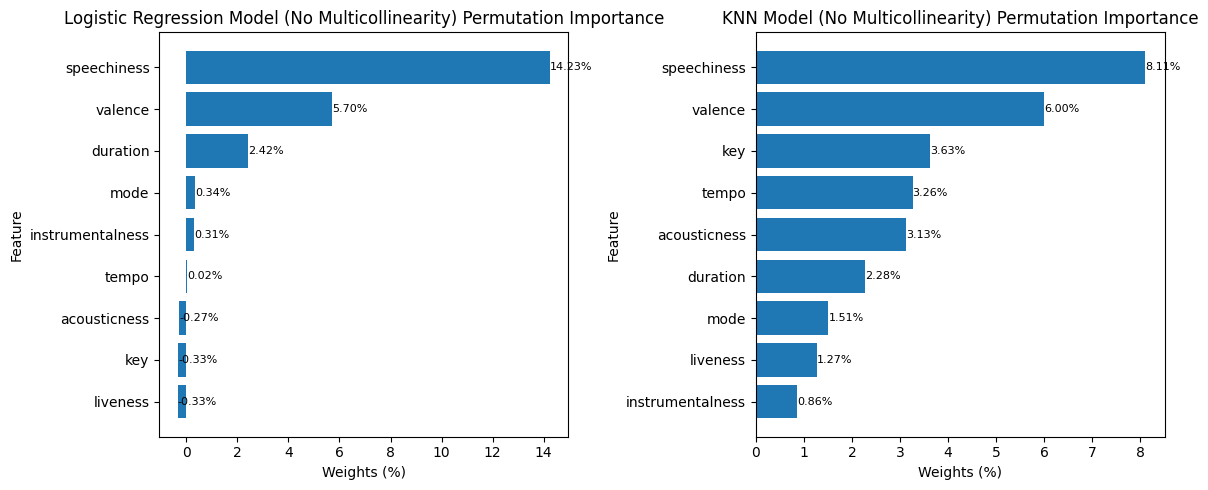

In [ ]:
feature_names = x_train2.columns

# Logistic Regression Permutation Importance
result_logreg = permutation_importance(logreg2, x_test2, y_test, n_repeats=100, random_state=42)
average_weights_logreg = result_logreg.importances_mean
sorted_indices_logreg = np.argsort(average_weights_logreg)
sorted_weights_logreg = average_weights_logreg[sorted_indices_logreg]
sorted_features_logreg = [feature_names[i] for i in sorted_indices_logreg]
sorted_weights_percentage_logreg = sorted_weights_logreg * 100

# KNN Permutation Importance
result_knn = permutation_importance(knn2, x_test2, y_test, n_repeats=100, random_state=42)
average_weights_knn = result_knn.importances_mean
sorted_indices_knn = np.argsort(average_weights_knn)
sorted_weights_knn = average_weights_knn[sorted_indices_knn]
sorted_features_knn = [feature_names[i] for i in sorted_indices_knn]
sorted_weights_percentage_knn = sorted_weights_knn * 100

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bars_logreg = ax1.barh(range(len(sorted_features_logreg)), sorted_weights_percentage_logreg)
ax1.set_yticks(range(len(sorted_features_logreg)))
ax1.set_yticklabels(sorted_features_logreg)
ax1.set_xlabel('Weights (%)')
ax1.set_ylabel('Feature')
ax1.set_title('Logistic Regression Model (No Multicollinearity) Permutation Importance')
for i, weight in enumerate(sorted_weights_percentage_logreg):
    ax1.text(weight, i, f'{weight:.2f}%', va='center', fontsize=8)

bars_knn = ax2.barh(range(len(sorted_features_knn)), sorted_weights_percentage_knn)
ax2.set_yticks(range(len(sorted_features_knn)))
ax2.set_yticklabels(sorted_features_knn)
ax2.set_xlabel('Weights (%)')
ax2.set_ylabel('Feature')
ax2.set_title('KNN Model (No Multicollinearity) Permutation Importance')
for i, weight in enumerate(sorted_weights_percentage_knn):
    ax2.text(weight, i, f'{weight:.2f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()